In [1]:
from torch import torch, nn, optim
import torch.nn.functional as F

In [2]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Get the data
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [3]:
# Create the network, define loss function and optimizer
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1))

loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

## Training

In [4]:
# Train the network
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #Flattening the input
        # images.shape[0] is gonna give us our batch size
        # -1 is gonna fill out the 2nd dimension with as many elements as it needs
        x = images.view(images.shape[0], -1)
        
        #Clear the gradient
        optimizer.zero_grad()
        
        #Training
        y_hat = model.forward(x)
        loss = loss_func(y_hat, labels)
        loss.backward()
        optimizer.step()
        
        running_loss = running_loss + loss.item()
    else:
        print(f'Training loss: {running_loss}')

Training loss: 483.84772492945194
Training loss: 370.29601983726025
Training loss: 333.56296207010746
Training loss: 312.24487037211657
Training loss: 296.2080166786909


## Inference and Validation

In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

dataiter = iter(testloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [6]:
# Create the network, define loss function and optimizer
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1))

loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [7]:
epochs = 20
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for training_images, training_labels in trainloader:
        x_train = training_images.view(training_images.shape[0], -1)
        
        optimizer.zero_grad()
        
        #Training
        y_hat_train = model.forward(x_train)
        training_loss = loss_func(y_hat_train, training_labels)
        training_loss.backward()
        optimizer.step()
        
        running_loss = running_loss + training_loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        #Inference
        #Turn off gradients for validation
        with torch.no_grad():
            running_test_loss = 0
            for test_images, test_labels in testloader:
                x_test = test_images.view(test_images.shape[0], -1)
                
                y_hat_test = model.forward(x_test)
                test_loss = loss_func(y_hat_test, test_labels)
                running_test_loss = running_test_loss + test_loss.item()
                
                ps = torch.exp(y_hat_test)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == test_labels.view(*top_class.shape)
                accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))
                
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(running_test_loss/len(testloader))
            
            print("Epochs: {}/{}.. ".format(e+1, epochs),
                 "Training Loss: {:.3f}..".format(running_loss/len(trainloader)),
                 "Test Loss: {:.3f}..".format(running_test_loss/len(testloader)),
                 "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epochs: 1/20..  Training Loss: 0.519.. Test Loss: 0.477.. Test Accuracy: 0.825
Epochs: 2/20..  Training Loss: 0.392.. Test Loss: 0.410.. Test Accuracy: 0.847
Epochs: 3/20..  Training Loss: 0.358.. Test Loss: 0.390.. Test Accuracy: 0.863
Epochs: 4/20..  Training Loss: 0.334.. Test Loss: 0.389.. Test Accuracy: 0.864
Epochs: 5/20..  Training Loss: 0.319.. Test Loss: 0.400.. Test Accuracy: 0.858
Epochs: 6/20..  Training Loss: 0.304.. Test Loss: 0.396.. Test Accuracy: 0.860
Epochs: 7/20..  Training Loss: 0.294.. Test Loss: 0.382.. Test Accuracy: 0.866
Epochs: 8/20..  Training Loss: 0.281.. Test Loss: 0.397.. Test Accuracy: 0.868
Epochs: 9/20..  Training Loss: 0.277.. Test Loss: 0.388.. Test Accuracy: 0.874
Epochs: 10/20..  Training Loss: 0.268.. Test Loss: 0.357.. Test Accuracy: 0.881
Epochs: 11/20..  Training Loss: 0.262.. Test Loss: 0.384.. Test Accuracy: 0.872
Epochs: 12/20..  Training Loss: 0.252.. Test Loss: 0.362.. Test Accuracy: 0.880
Epochs: 13/20..  Training Loss: 0.249.. Test Loss

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

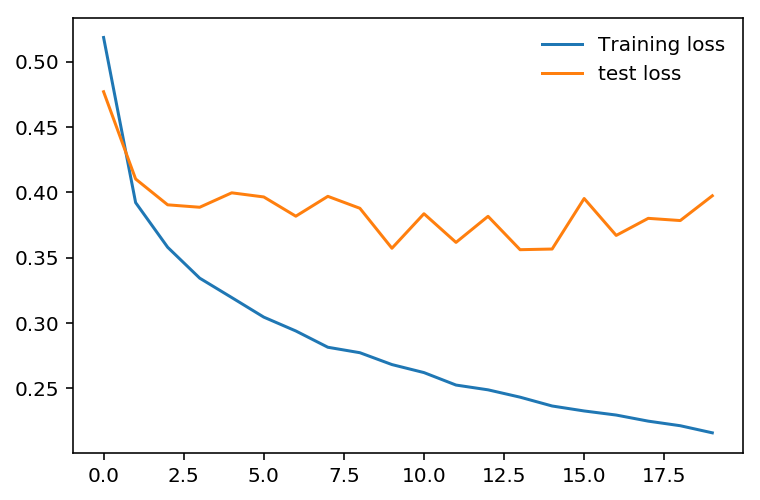

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='test loss')
plt.legend(frameon=False)

## Overfitting

The sign that the model is overfitting is when the validation error starts to get worse

### Dropout

In [12]:
# Create the network, define loss function and optimizer
model_with_dropout = nn.Sequential(nn.Dropout(p=0.3),
                                   nn.Linear(784, 512),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.3),
                                   nn.Linear(512, 256),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.3),
                                   nn.Linear(256, 128),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.3),
                                   nn.Linear(128, 64),
                                   nn.ReLU(),
                                   nn.Linear(64,10),
                                   nn.LogSoftmax(dim=1))

loss_func = nn.NLLLoss()
optimizer = optim.Adam(model_with_dropout.parameters(), lr=0.003)

In [13]:
epochs = 20
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    
    #Training pass
    for training_images, training_labels in trainloader:
        x_train = training_images.view(training_images.shape[0], -1)
        
        optimizer.zero_grad()
        
        #Training
        y_hat_train = model_with_dropout.forward(x_train)
        training_loss = loss_func(y_hat_train, training_labels)
        training_loss.backward()
        optimizer.step()
        
        running_loss = running_loss + training_loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        #Inference
        #Turn off gradients for validation
        with torch.no_grad():
            
            # set model to evaluation mode (e.g. No Dropout)
            model_with_dropout.eval()
            
            # Validation pass through the test data
            running_test_loss = 0
            for test_images, test_labels in testloader:
                x_test = test_images.view(test_images.shape[0], -1)
                
                y_hat_test = model_with_dropout.forward(x_test)
                test_loss = loss_func(y_hat_test, test_labels)
                running_test_loss = running_test_loss + test_loss.item()
                
                ps = torch.exp(y_hat_test)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == test_labels.view(*top_class.shape)
                accuracy = accuracy + torch.mean(equals.type(torch.FloatTensor))
            
            #Set the model to training mode again so to have dropout on 
            model_with_dropout.train()
            
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(running_test_loss/len(testloader))
            
            print("Epochs: {}/{}.. ".format(e+1, epochs),
                 "Training Loss: {:.3f}..".format(running_loss/len(trainloader)),
                 "Test Loss: {:.3f}..".format(running_test_loss/len(testloader)),
                 "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epochs: 1/20..  Training Loss: 0.684.. Test Loss: 0.511.. Test Accuracy: 0.809
Epochs: 2/20..  Training Loss: 0.554.. Test Loss: 0.457.. Test Accuracy: 0.836
Epochs: 3/20..  Training Loss: 0.531.. Test Loss: 0.469.. Test Accuracy: 0.823
Epochs: 4/20..  Training Loss: 0.510.. Test Loss: 0.430.. Test Accuracy: 0.850
Epochs: 5/20..  Training Loss: 0.506.. Test Loss: 0.447.. Test Accuracy: 0.844
Epochs: 6/20..  Training Loss: 0.504.. Test Loss: 0.429.. Test Accuracy: 0.844
Epochs: 7/20..  Training Loss: 0.494.. Test Loss: 0.417.. Test Accuracy: 0.846
Epochs: 8/20..  Training Loss: 0.481.. Test Loss: 0.431.. Test Accuracy: 0.848
Epochs: 9/20..  Training Loss: 0.483.. Test Loss: 0.413.. Test Accuracy: 0.854
Epochs: 10/20..  Training Loss: 0.477.. Test Loss: 0.417.. Test Accuracy: 0.855
Epochs: 11/20..  Training Loss: 0.481.. Test Loss: 0.422.. Test Accuracy: 0.853
Epochs: 12/20..  Training Loss: 0.472.. Test Loss: 0.406.. Test Accuracy: 0.857
Epochs: 13/20..  Training Loss: 0.475.. Test Loss

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

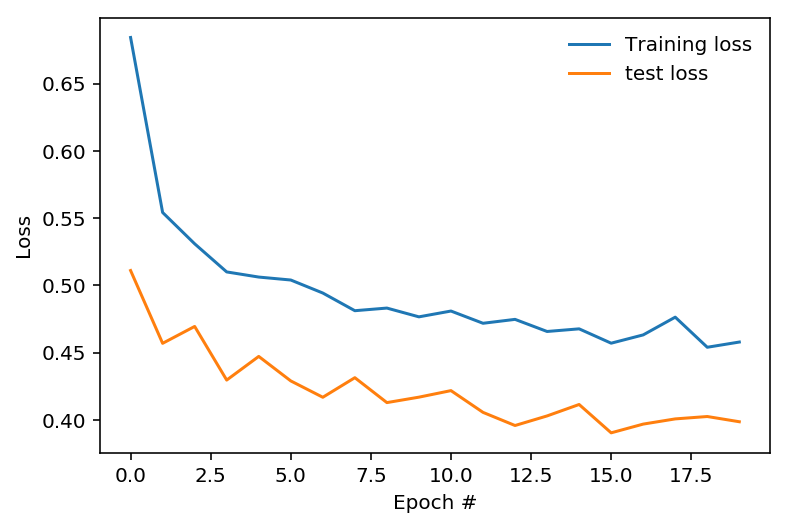

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(frameon=False)